In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import fabio, sys, h5py, os

sys.path.insert(0, '../02-scripts/')
from integrators import *
from utilities import *
from calibrators import *


/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load data

In [2]:
# import calibrated Qs
q = np.load('../04-processed/q.npy')
mask = np.load('../04-processed/mask.npy')
x,y = np.load('../04-processed/centers.npy')

# import calibrator
Ih_ref = iceIh_peaks()

## Angular average

In [3]:
# background 
bg_fn = '../03-data/02-blank-296.sfrm'
im_bg = fabio.open(bg_fn)
bg_ar = np.array(im_bg.data, dtype=float)

Parameters 

In [4]:
# -- angular integration parameters
n_bins = len(q)    # number of bins
mask_thr = 0    # threshold limit for integrator

p_size = 96e-6        # size of the pixels
d = 50e-3              # detector distance
Cu_energy = 8041.       # energy of the beam (Cu K\alpha)

Background angular average

In [5]:
# r-map
rad_dist = radial_distances(bg_ar, center=(int(y),int(x)))

# angular average
# bg_ar is a 2d array (the image)
r_bg,iq_bg = angular_average(bg_ar, mask=mask, rad=rad_dist, threshold=mask_thr, nx=n_bins)

## Angular averages of all samples

**Function**

In [6]:
def ang_and_plot(filename):
    """compute angular average from the row file"""
    img = fabio.open(filename) # bruker type
    img2d = np.array(img.data,dtype=float) # array type
    r, Iq = angular_average(img2d, mask=mask, rad=rad_dist,threshold=mask_thr,nx=n_bins)
    return Iq

**Compute the angular average for some samples**

In [7]:
# background
Iq_bg = ang_and_plot('../03-data/02-blank-296.sfrm')

In [8]:
# function to subtract the background
def subtr_offset(Iq, Iq_bg, w=1.):
    """subtract the background in a weighted manner"""
    off = Iq_bg[0] - Iq[0]
    Iq_npbg = Iq - w*(Iq_bg-off)
    
    return Iq_npbg

## Loop over all files

In [9]:
datadir = '../03-data/'
files = sorted([f for f in os.listdir(datadir) if (os.path.isfile(os.path.join(datadir, f)) and f[-4:]=='sfrm')])

In [10]:
for i in range(len(files)):
    print(i, files[i])

0 01-Ag-behenate-296.sfrm
1 02-blank-296.sfrm
2 03-A3641-conc-296.sfrm
3 04-A3641-conc-273.sfrm
4 05-A3641-conc-268.sfrm
5 06-A3641-conc-266.sfrm
6 07-A3641-conc-263.sfrm
7 08-A3641-conc-260.sfrm
8 09-F4503-conc-296.sfrm
9 10-F4503-conc-273.sfrm
10 11-F4503-conc-268.sfrm
11 12-F4503-conc-266.sfrm
12 13-F4503-conc-263.sfrm
13 14-F4503-conc-260.sfrm
14 15-F4503-conc-257.sfrm
15 16-F4503-conc-296.sfrm
16 17-blank-quartz-296.sfrm
17 18-calibrator-xfel.sfrm


In [11]:
# save all Iq in one array: with and without bg
Iq_all = np.empty(shape=(len(files), n_bins))
Iq_all_nobg = np.empty(shape=(len(files), n_bins))

for i in range(len(files)):
    Iq_all[i] = ang_and_plot(f'../03-data/{files[i]}')
    if ('blank' or 'kapton') in files[i]:
        Iq_all_nobg[i] = Iq_bg
    else:
        Iq_all_nobg[i] = subtr_offset(Iq_all[i], Iq_bg, w=.9)

In [12]:
# samples: give your preferred name and index range
A3641_c = Iq_all_nobg[2:8,:]
F4503_c = Iq_all_nobg[8:16,:]

## All measurements

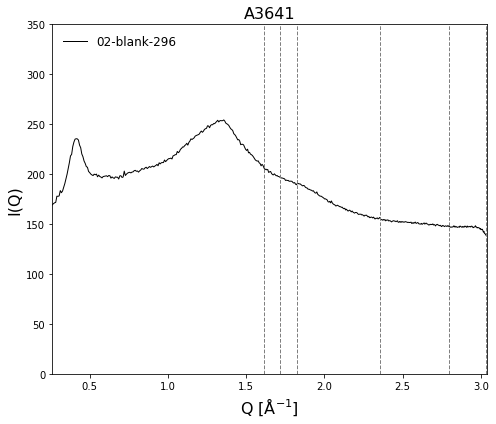

In [13]:
# plot files
plt.figure(figsize=(7,6))
col = plt.cm.coolwarm_r(np.linspace(0,1,3))

# A3641 conc
plt.plot(q, Iq_all[1,:], c='k', lw=1, label=f'{files[1][:-5]}')

for ice in Ih_ref: plt.axvline(x=ice, ls='--', lw=1, c='gray')

plt.xlabel(r'Q [$\rm\AA^{-1}$]', fontsize=16)
plt.ylabel(r'I(Q)', fontsize=16)
plt.xlim(q[0], q[-1])
plt.ylim(0, 350)
plt.title(files[3][3:8], fontsize=16)
plt.legend(frameon=False, fontsize=12)
plt.tight_layout()
#plt.savefig('/Users/maddalena/Desktop/apof.png', dpi=300)
plt.show()

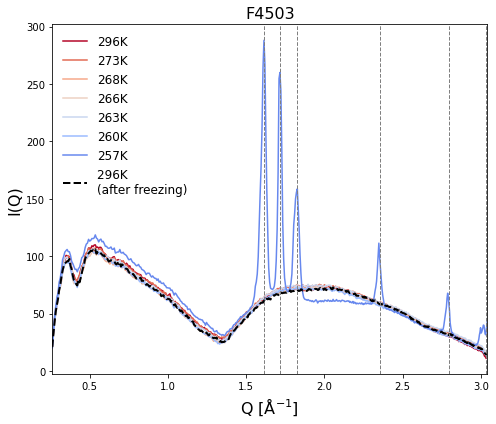

In [14]:
# plot files
plt.figure(figsize=(7,6))
col = plt.cm.coolwarm_r(np.linspace(0,1,len(F4503_c)))

# F4503 conc
for i in range(len(F4503_c)-1):
    #plt.plot(q, F4503_c[i,:]/np.max(F4503_c[i,:]), c=col[i], lw=1, label=f'{files[i+2][:-5]}')
    plt.plot(q, F4503_c[i,:], c=col[i], lw=1.5, label=f'{files[i+8][-8:-5]}K')
plt.plot(q, F4503_c[-1,:], c='k', lw=2, ls='--', label=f'{files[15][-8:-5]}K \n(after freezing)')

for ice in Ih_ref: plt.axvline(x=ice, ls='--', lw=1, c='gray')
plt.xlabel(r'Q [$\rm\AA^{-1}$]', fontsize=16)
plt.ylabel(r'I(Q)', fontsize=16)
plt.xlim(q[0], q[-1])
plt.legend(frameon=False, fontsize=12)
plt.title(files[8][3:8], fontsize=16)
plt.tight_layout()
# plt.savefig('/Users/maddalena/Desktop/Iq.png', dpi=300)
plt.show()

# Save Iq in h5 file (not necessary)

In [16]:
date_today = '2023-02-23'
save = False

In [52]:
if save == True:
    f = h5py.File(f'../04-processed/{date_today}-all.hdf5', 'w') # w stads for write

    g1 = f.create_group('tool')
    g1.create_dataset('calibrator', data=Iq_all[0])
    g1.create_dataset('background', data=Iq_all[1])
    
    # g2 = f.create_group('Iq')
    # g2.create_dataset('Lys200_vol', data=Iq_all[7:15])
    #g2.create_dataset('Lys200_wei', data=Iq_all[22:27])
    #g2.create_dataset('Wat-Gly_11v', data=Iq_all[2:7])
    
    f.visititems(visit_func)   
    f.close()

/tool
	 /tool/background (500,)
	 /tool/calibrator (500,)


In [53]:
f = h5py.File(f'../04-processed/{date_today}-all.hdf5', 'r')
f.visititems(visit_func)   
f.close()


/tool
	 /tool/background (500,)
	 /tool/calibrator (500,)
